In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
import distclassipy as dcpy
from tqdm.auto import tqdm

os.chdir("../")
from pathlib import Path
import matplotlib.gridspec as gridspec
import sys

sys.path.append("scripts")
import utils

In [2]:
with open("settings.txt") as f:
    settings_dict = json.load(f)
seed_val = settings_dict["seed_choice"]
np.random.seed(seed_val)
sns_dict = settings_dict["sns_dict"]
sns.set_theme(**sns_dict)

In [3]:
# custom_hues = ["#3B4CC0", "#1FA187", "#FBAE17", "#D21F26"]
ibm_palette_hues = ["#648FFF", "#785EF0", "#DC267F", "#FE6100", "#FFB000"]
# https://davidmathlogic.com/colorblind/
sns.set_palette(ibm_palette_hues)

In [4]:
# all_metrics = settings_dict["all_metrics"]
# all_metrics = dcpy._ALL_METRICS
all_metrics = ['euclidean',
 'braycurtis',
 'canberra',
 'cityblock',
 'chebyshev',
 'clark',
 'correlation',
 'cosine',
 'hellinger',
 'jaccard',
 'lorentzian',
 'marylandbridge',
 'meehl',
 # 'motyka',
 'soergel',
 'wave_hedges',
 'kulczynski',
 'add_chisq',
 'acc',
 'chebyshev_min',
 # 'czekanowski',
 'dice',
 'divergence',
 'google',
 # 'gower',
 'jeffreys',
 # 'jensenshannon_divergence',
 # 'jensen_difference',
 'kumarjohnson',
 # 'matusita',
 # 'minkowski',
 'penroseshape',
 # 'prob_chisq',
 # 'ruzicka',
 # 'sorensen',
 'squared_chisq',
 'squaredchord',
 'squared_euclidean',
 'taneja',
 # 'tanimoto',
 'topsoe',
 'vicis_symmetric_chisq',
 'vicis_wave_hedges']


In [5]:
reduced_features = pd.read_parquet("data/reduced_features.parquet")
reduced_features["class"].value_counts()

class
EB      98473
RRL     45096
DSCT     8245
CEP      1662
Name: count, dtype: int64

In [6]:
# n_cols = 5
n_objs = 1000

# 69% Features: ['Harmonics_phase_5_Y', 'Harmonics_mse_Y', 'Harmonics_mag_7_Y', 'Harmonics_phase_3_z', 'n_forced_phot_band_after_Y', 'Harmonics_phase_4_g', 'max_brightness_after_band_g', 'Harmonics_phase_2_z', 'Harmonics_phase_2_z', 'Harmonics_phase_3_z']
# 65% Features: ['Harmonics_phase_6_r', 'Power_rate_4', 'Harmonics_mag_5_Y', 'Harmonics_phase_3_g', 'r-i']
# 80% Features: ['Power_rate_4', 'Harmonics_mag_5_Y', 'Harmonics_phase_3_r', 'r-i']

col_select = ["Power_rate_4", "Harmonics_mag_5_Y", "r-i", "Multiband_period"]
print(f"Features: {col_select}")
temp = reduced_features.loc[:, col_select + ["class"]].dropna()
assert (temp["class"].value_counts() > n_objs).all()

Features: ['Power_rate_4', 'Harmonics_mag_5_Y', 'r-i', 'Multiband_period']


In [7]:
# temp = temp.groupby("class").sample(n=n_objs)
temp = temp.sample(frac=1, random_state=seed_val)

In [8]:
X = temp[col_select].to_numpy()
y = temp["class"].to_numpy()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=settings_dict["seed_choice"]
)

In [10]:
lcdc = dcpy.DistanceMetricClassifier(
    scale=True,
    central_stat="median",
    dispersion_stat="std",
)

In [11]:
lcdc.fit(X_train, y_train)

DistanceMetricClassifier()

In [12]:
y_pred_test = lcdc.predict_and_analyse(X_test, metric="canberra")
y_testdf = pd.DataFrame(data=y_test, columns=["class"])
y_testdf["pred"] = y_pred_test

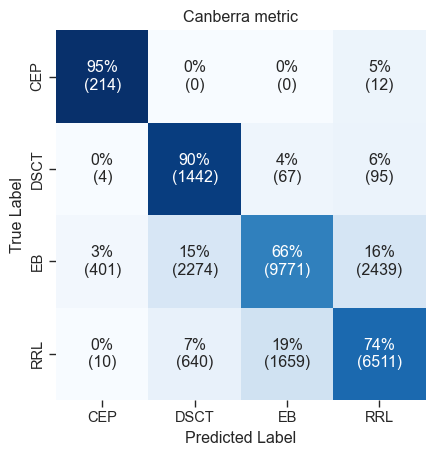

F1 = 61.33 %
Accuracy = 70.24 %
Matthew's Coefficient = 52.22 %


In [13]:
acc = accuracy_score(y_test, y_pred_test)
f1score = f1_score(y_test, y_pred_test, average="macro")
matthew_coef = matthews_corrcoef(y_test, y_pred_test)

ax = utils.plot_cm(y_true=y_test, y_pred=y_pred_test)
ax.set_title(f"Canberra metric")
plt.show()

print(
    f"F1 = {f1score*100:.2f} %\nAccuracy = {acc*100:.2f} %\nMatthew's Coefficient = {matthew_coef*100:.2f} %"
)

In [14]:
y = temp["class"].to_numpy()
X = temp.drop("class", axis=1).to_numpy()

In [15]:
# check_sigma = 5
# snidflagged = []
# for metric in tqdm(all_metrics, desc="Metric", leave=True):
#     metric_str = utils.get_metric_name(metric)
#     lcdc.fit(X, y)
#     _ = lcdc.predict_and_analyse(X, metric=metric)

#     dist_df = lcdc.centroid_dist_df_
#     dist_df.index=temp.index
#     mean_distdf = dist_df.mean()
#     sig_distdf = dist_df.std()
    
#     is_outlier_df = (dist_df < (mean_distdf - check_sigma / 2 * sig_distdf)) | (dist_df > (mean_distdf + check_sigma / 2 * sig_distdf))
#     row_has_an_outlier = is_outlier_df.all(axis=1) # far away from all
#     outliers = dist_df.loc[row_has_an_outlier]
#     snidflagged = snidflagged + list(outliers.index)
#     outliers.to_csv(os.path.join("results",f"outliers_{metric_str}.csv"))
# snidflagged=np.array(snidflagged)
# snidflagged = pd.DataFrame(snidflagged, columns=["snid"])

In [17]:
check_sigma = 5
outlier_info_by_snid = {}

for metric in tqdm(all_metrics, desc="Metric", leave=True):
    metric_str = utils.get_metric_name(metric)
    locpath = os.path.join("results", metric_str)
    lcdc.fit(X, y)
    _ = lcdc.predict_and_analyse(X, metric=metric)

    dist_df = lcdc.centroid_dist_df_
    dist_df.index=temp.index
    mean_distdf = dist_df.mean() # try median
    sig_distdf = dist_df.std() # try iqr
    
    is_outlier_df = (dist_df < (mean_distdf - check_sigma / 2 * sig_distdf)) | (dist_df > (mean_distdf + check_sigma / 2 * sig_distdf))
    row_has_an_outlier = is_outlier_df.all(axis=1) # far away from ALL other classes!
    current_metric_outliers_df = dist_df.loc[row_has_an_outlier] 
    
    # Record which metric flagged which SNID
    for snid_val in current_metric_outliers_df.index:
        outlier_info_by_snid.setdefault(snid_val, []).append(metric_str)
            
    current_metric_outliers_df.to_csv(os.path.join(f"{locpath}/outliers.csv"))

Metric:   0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
# Convert the dictionary of outlier information to a DataFrame
records = []
for snid_val, metrics_list in outlier_info_by_snid.items():
    records.append({'snid': snid_val, 
                    'flagged_by_metrics': metrics_list, 
                    'num_flagging_metrics': len(metrics_list)})

In [ ]:
snidflagged = pd.DataFrame(records)
# Sort by the number of flagging metrics (descending), then by snid (ascending for tie-breaking)
snidflagged = snidflagged.sort_values(
    by=['num_flagging_metrics', 'snid'], 
    ascending=[False, True]
).reset_index(drop=True)

In [18]:
dist_df.median()

CEP_dist     53.341205
DSCT_dist    14.201498
EB_dist      10.214498
RRL_dist     11.163008
dtype: float64

In [19]:
records = []
for snid_val, metrics_list in outlier_info_by_snid.items():
    records.append({'snid': snid_val, 
                    'flagged_by_metrics': metrics_list, 
                    'num_flagging_metrics': len(metrics_list)})

# Define expected columns to handle empty 'records' gracefully without an if/else
snidflagged_columns = ['snid', 'flagged_by_metrics', 'num_flagging_metrics']
snidflagged = pd.DataFrame(records, columns=snidflagged_columns)

# Add 'class' column from the 'temp' DataFrame.
# Assumes 'temp' is indexed by SNID and has a 'target' column for class labels.
# Adjust temp['target'] if your class column in 'temp' has a different name,
# or if class information is directly in the 'y' Series (e.g., using y.loc[snid_val] or snidflagged['snid'].map(y)).
snidflagged['class'] = snidflagged['snid'].map(temp['class'])

# Reorder columns for better readability
# Ensure 'class' is included, handling the case where it might not have been successfully added
final_columns = ['snid', 'class', 'num_flagging_metrics', 'flagged_by_metrics']
snidflagged = snidflagged.reindex(columns=final_columns)


# Sort by the number of flagging metrics (descending), then by snid (ascending for tie-breaking)
# This will work even if snidflagged is empty.
snidflagged = snidflagged.sort_values(
    by=['num_flagging_metrics', 'snid'], 
    ascending=[False, True]
).reset_index(drop=True)

In [20]:
snidflagged["class"].value_counts()

class
EB      367
CEP      47
RRL       8
DSCT      1
Name: count, dtype: int64

In [21]:
snidflagged["snid"]

0      149102008
1       89400191
2      111699711
3      132147317
4      155825094
         ...    
418    158627057
419    159018870
420    159274965
421    159443675
422    159456645
Name: snid, Length: 423, dtype: int64

In [25]:
snidflagged["snid"].value_counts() / len(all_metrics)
# Percentage of metrics which flagged it as an outlier

snid
149102008    0.03125
101802759    0.03125
108651290    0.03125
108559610    0.03125
108469927    0.03125
              ...   
37162103     0.03125
36884009     0.03125
35652738     0.03125
34672398     0.03125
159456645    0.03125
Name: count, Length: 423, dtype: float64

In [26]:
outlier_classes = temp.loc[snidflagged["snid"].to_numpy().ravel(), "class"]

In [27]:
np.argwhere(outlier_classes=="CEP")

array([[ 61],
       [ 66],
       [ 71],
       [ 73],
       [ 75],
       [ 77],
       [ 78],
       [ 79],
       [ 81],
       [ 82],
       [ 83],
       [ 85],
       [ 87],
       [ 88],
       [ 93],
       [ 96],
       [ 99],
       [106],
       [107],
       [108],
       [110],
       [117],
       [133],
       [140],
       [141],
       [142],
       [147],
       [148],
       [149],
       [153],
       [158],
       [178],
       [184],
       [187],
       [271],
       [273],
       [279],
       [288],
       [298],
       [322],
       [324],
       [328],
       [355],
       [358],
       [370],
       [377],
       [391]])

In [28]:
snidflagged.iloc[61]

snid                                               56961335
class                                                   CEP
num_flagging_metrics                                      3
flagged_by_metrics      [Canberra, Wave_Hedges, Divergence]
Name: 61, dtype: object

---

In [29]:
snid = 56961335

In [30]:
lcdf = pd.read_parquet("data/Cepheid.parquet")
lcdf=lcdf.set_index("SNID")

In [31]:
def plot_lc(lcdf, snid):
    chosen_df = lcdf.loc[snid]
    cols = ["MJD", "FLUXCAL", "FLUXCALERR", "BAND", "PHOTFLAG", "ZEROPT"]
    dat = []
    for col in cols:
        if col in cols:
            dat.append(chosen_df.loc[col])
    dat = np.array(dat).T
    lc = pd.DataFrame(data=dat,columns=cols).sort_values(by="MJD")

    for band in "ugrizY":
        lc_band = lc[lc["BAND"] == band]
        plt.errorbar(
            x=lc_band["MJD"],
            y=lc_band["FLUXCAL"],
            yerr=lc_band["FLUXCALERR"],
            fmt="o",
            label=f"{band}",
        )
    plt.xlabel("Time (in days)")
    plt.ylabel("Brightness (flux)")
    plt.legend()
    # plt.title(f"OID {objid} ({cur_cl})")
    # plt.xlim(peak_mjd - 40, peak_mjd + 90)
    # plt.grid()
    # plt.savefig("rawlc_crop.pdf", bbox_inches="tight")
    plt.show()

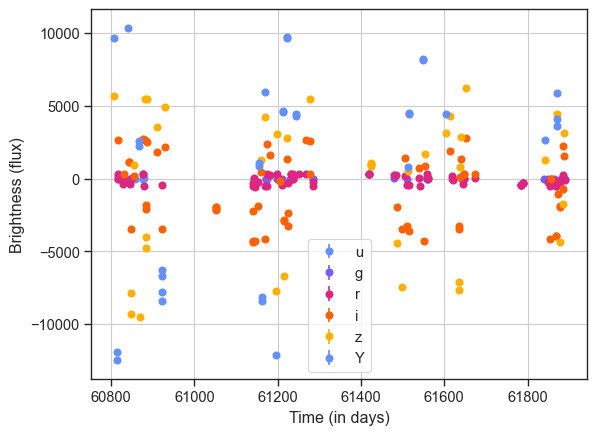

In [32]:
plot_lc(lcdf,56961335)